In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [3]:
device = "mps" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [4]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 84825


In [6]:
features = np.load("train_features_axial_monai.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("train_labels_axial_monai.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("train_image_paths_axial.npy") # Shape: (84755,)
print(image_paths.shape)


(96087, 50176)
(96087,)
(169650,)


In [7]:
features = np.load("val_features_axial_monai.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("val_labels_axial_monai.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("val_image_paths_axial.npy") # Shape: (84755,)
print(image_paths.shape)


(8415, 50176)
(8415,)
(8415,)


In [23]:
# for text embeddings
import pandas as pd

# Load your file
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv")

# Preview the first few rows
print(df.shape)
df.head()


(2294, 51)


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,...,AXCRYING,AXELMOOD,AXWANDER,AXFALL,AXOTHER,ID,SITEID,USERDATE,USERDATE2,update_stamp
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/1/2008,...,1.0,1.0,1.0,1.0,1.0,4150.0,127.0,5/5/2008,NaN,00:00.0
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,...,1.0,1.0,1.0,1.0,2.0,2370.0,127.0,9/18/2007,NaN,00:00.0
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/2/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,...,1.0,1.0,1.0,2.0,1.0,2110.0,127.0,8/15/2007,NaN,00:00.0


In [24]:
import pandas as pd
import clip
import torch

model, preprocess = clip.load("ViT-B/32", device=device)
# Remove label 
df_cleaned = df.drop(columns=["Group", "Downloaded", "Modality", "Type", "Format"])

# Keep Image ID separately for future mapping
image_ids = df_cleaned["Image Data ID"].values

# Drop ID from the text encoding input
text_only = df_cleaned.drop(columns=["Image Data ID"])

# Convert each row to string and generate sentence embeddings
texts = text_only.astype(str).agg(" ".join, axis=1).tolist()
texts = [t.lower().strip() for t in texts]

# Tokenize all text using CLIP
text_tokens = clip.tokenize(texts, truncate=True).to(device)

# Generate text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()  # shape: (n_samples, 512)
# Save with Image IDs
import numpy as np
np.save("text_embeddings_cleaned_for_PCA.npy", text_embeddings)
np.save("text_image_ids_for_PCA.npy", image_ids)


In [25]:
print("Total samples in df_cleaned:", df_cleaned.shape[0])
print("Unique Image IDs in df_cleaned:", df_cleaned["Image Data ID"].nunique())

Total samples in df_cleaned: 2294
Unique Image IDs in df_cleaned: 2294


In [26]:
import numpy as np
import pandas as pd

# Load the cleaned text embeddings and associated image IDs
text_embeddings = np.load("text_embeddings_cleaned_for_PCA.npy")           # shape: (2294, 384)
text_image_ids = np.load("text_image_ids_for_PCA.npy", allow_pickle=True)  # shape: (2294,)

# Convert to DataFrame and add IDs as the first column
df = pd.DataFrame(text_embeddings)
df.insert(0, "Image_ID", text_image_ids)

# Save to CSV
df.to_csv("text_embeddings_cleaned_with_ids_monai_for_PCA.csv", index=False)

print(" Saved: text_embeddings_cleaned_with_ids_monai_for_PCA.csv")
print(" Shape:", df.shape)


 Saved: text_embeddings_cleaned_with_ids_monai_for_PCA.csv
 Shape: (2294, 513)


In [1]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("train_features_axial_monai.npy")      
image_labels = np.load("train_labels_axial_monai.npy")     
image_paths = np.load("train_image_paths_axial.npy")      

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned_for_PCA.npy")   # (2294, 384)
text_ids = np.load("text_image_ids_for_PCA.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("train_fused_features_clean_monai_for_PCA.npy", fused_features)
np.save("train_fused_labels_clean_monai_for_PCA.npy", fused_labels)
print(" Final train fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


python(22890) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
 57%|█████▋    | 96087/169650 [01:35<01:13, 1007.26it/s]


 Matched samples: 96087


: 

In [ ]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("val_features_axial_monai.npy")      
image_labels = np.load("val_labels_axial_monai.npy")     
image_paths = np.load("val_image_paths_axial.npy")      

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned_for_PCA.npy")   # (2294, 384)
text_ids = np.load("text_image_ids_for_PCA.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_clean_monai_for_PCA.npy", fused_features)
np.save("val_fused_labels_clean_monai_for_PCA.npy", fused_labels)

print(" Final train fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 8415/8415 [00:01<00:00, 4470.97it/s]


 Matched samples: 8415
 Final train fused shape: (8415, 50688)
 Labels shape: (8415,)


In [ ]:
# Load Training Set
X = np.load("train_fused_features_clean_monai_for_PCA.npy")
y = np.load("train_fused_labels_clean_monai_for_PCA.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
# df.to_csv("train_fused_embeddings_with_labels_for_PCA.csv", index=False)
# print(" Saved: train_fused_embeddings_with_labels_for_PCA.csv")

print(" Saved:")
print("  train_fused_features_clean_for_PCA.npy (shape:", X.shape, ")")
print("  train_fused_labels_clean_for_PCA.npy  (shape:", y.shape, ")")

# Load Validation Set
X = np.load("val_fused_features_clean_monai_for_PCA.npy")
y = np.load("val_fused_labels_clean_monai_for_PCA.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
# df.to_csv("val_fused_embeddings_with_labels.csv", index=False)
# print(" Saved: val_fused_embeddings_with_labels.csv")

print(" Saved:")
print("  val_fused_features_clean_for_PCA.npy (shape:", X.shape, ")")
print("  val_fused_labels_clean_for_PCA.npy  (shape:", y.shape, ")")

FileNotFoundError: [Errno 2] No such file or directory: 'train_fused_features_clean_monai_for_PCA.npy'

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

X_train = np.load("train_fused_features_clean_monai_for_PCA.npy")
X_val = np.load("val_fused_features_clean_monai_for_PCA.npy")

# Reduce to 300 dimensions
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Save reduced features
np.save("train_fused_pca_100.npy", X_train_pca)
np.save("val_fused_pca_100.npy", X_val_pca)

print("Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance: 0.9997868609465466


In [17]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 3)  # 3 classes: AD, CN, MCI

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # raw logits for CrossEntropyLoss
        return x

# Example usage:
input_dim = X_train.shape[1]
model = MLPWithDropout(input_dim).to(device)

In [18]:
# run this for no randomness
import torch
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional for PyTorch >=1.8
    torch.use_deterministic_algorithms(True)

Using device: cpu
Epoch 1/100 | Train Loss: 0.9785 | Val Loss: 1.0494
Epoch 2/100 | Train Loss: 0.7488 | Val Loss: 1.0840
Epoch 3/100 | Train Loss: 0.6428 | Val Loss: 1.0750
Epoch 4/100 | Train Loss: 0.5563 | Val Loss: 1.0371
Epoch 5/100 | Train Loss: 0.4979 | Val Loss: 1.0272
Epoch 6/100 | Train Loss: 0.4605 | Val Loss: 1.0177
Epoch 7/100 | Train Loss: 0.4325 | Val Loss: 1.0464
Epoch 8/100 | Train Loss: 0.4147 | Val Loss: 1.0353
Epoch 9/100 | Train Loss: 0.3967 | Val Loss: 1.0527
Epoch 10/100 | Train Loss: 0.3817 | Val Loss: 1.0556
Epoch 11/100 | Train Loss: 0.3693 | Val Loss: 1.0678
⏹ Early stopping at epoch 11
Training Accuracy: 0.8707
Validation Accuracy: 0.5872
Classification Report:
               precision    recall  f1-score   support

          AD       0.58      0.56      0.57      1870
          CN       0.50      0.55      0.52      2585
         MCI       0.66      0.63      0.64      3960

    accuracy                           0.59      8415
   macro avg       0.58      

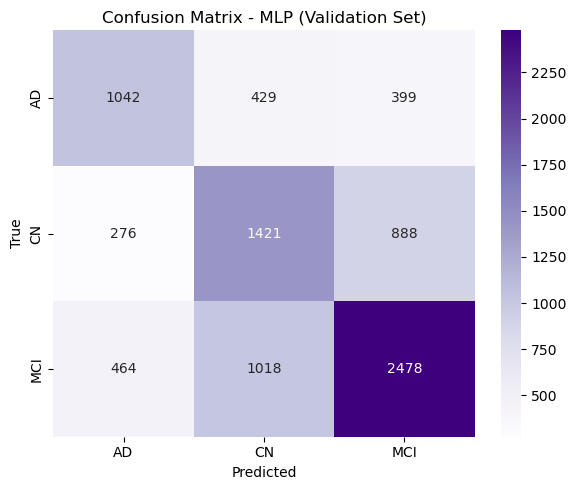

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# ---------------- Load Data ----------------
X_train = np.load("train_fused_pca_100.npy")
y_train = np.load("train_fused_labels_clean_monai.npy")
X_val = np.load("val_fused_pca_100.npy")
y_val = np.load("val_fused_labels_clean_monai.npy")

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Balance training set
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# ---------------- Model Definition ----------------
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 3)  # 3 classes: AD, CN, MCI

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # raw logits
        return x

# ---------------- Training Setup ----------------
input_dim = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLPWithDropout(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

num_epochs = 100
patience = 5
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0
best_model_state = None

# ---------------- Training Loop ----------------
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    y_val_preds, y_val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            preds = torch.argmax(out, dim=1)
            y_val_preds.extend(preds.cpu().numpy())
            y_val_true.extend(yb.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1}")
            break

# ---------------- Evaluation ----------------
model.load_state_dict(best_model_state)

# Training set accuracy
model.eval()
y_train_preds, y_train_true = [], []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

train_acc = accuracy_score(y_train_true, y_train_preds)
print(f"Training Accuracy: {train_acc:.4f}")

# Validation set accuracy
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f"Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["AD", "CN", "MCI"]))

# Confusion matrix
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

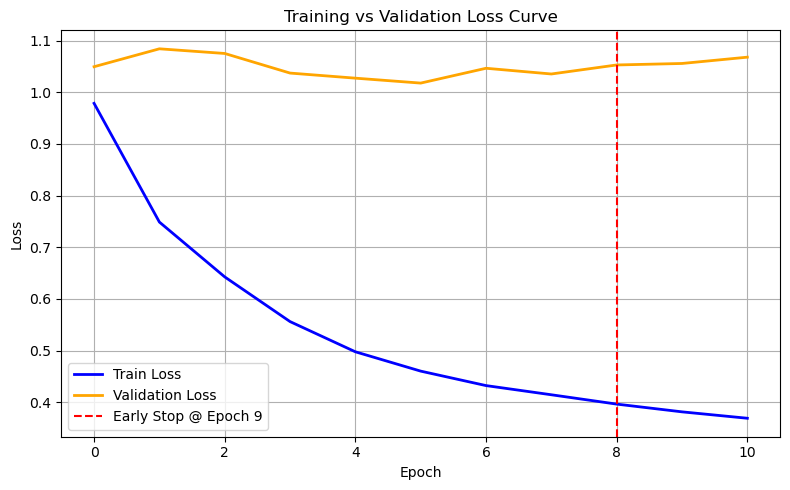

In [22]:
# Loss Curve with Early Stopping Marker
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)

# Mark early stopping epoch
if early_stop_epoch != -1:
    plt.axvline(early_stop_epoch, color='red', linestyle='--', label=f"Early Stop @ Epoch {early_stop_epoch+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()